In [1]:
from constants import ART_CLASS_LABELS
from model.model import AttentionConvNeXt
import torch
from torchvision.transforms.functional import to_pil_image
import pickle
import numpy as np

from service.prediction import PredictionService
from service.localisation import LocalisationService
from utils.inferencing import InferencingService

from PIL import Image
import matplotlib.pyplot as plt

from constants import IMG_H, IMG_W, FM_CAM_TYPE ,G_CAM_TYPE

In [2]:
with open('../model/preprocess_transforms.pt', 'rb') as f:
    preprocess_transforms = pickle.load(f)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

art_brain_model = AttentionConvNeXt(len(ART_CLASS_LABELS)).to(device)
art_brain_model.load_state_dict(torch.load("../model/artbrain_top_model_weights.pt", map_location=device))
art_brain_model.eval()

AttentionConvNeXt(
  (convnext): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=512, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=512, out_features=128, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2

# Prediction + Localisation Service Test

In [3]:
prediction_service = PredictionService(
    model=art_brain_model,
    last_conv_layer=art_brain_model.attention_module
)

In [4]:

# Input Sample
art_image = Image.open("./test_files/Starry-Night-canvas-Vincent-van-Gogh-New-1889.jpg")
art_image = art_image.resize((IMG_H, IMG_W), resample=Image.BICUBIC)
art_img_tensor = preprocess_transforms(art_image)

## FMGCAM Prediction Type

In [5]:
preds, sorted_pred_index, grad_list, act_list = prediction_service.get_model_pred(
    art_img_tensor.to(device),
    FM_CAM_TYPE
)

In [6]:
len(preds), np.argmax(preds)

(30, 24)

In [7]:
len(grad_list), len(act_list)

(3, 3)

In [8]:
grad_list[0][0].size(), act_list[0][0].size()

(torch.Size([1, 3072, 7, 7]), torch.Size([3072, 7, 7]))

## FMGCAM Localisation

In [9]:
localisation_service = LocalisationService()
fmgcam_hm = localisation_service.generate_fmgcam(
    gradients_list=grad_list,
    activations_list=act_list
)
fmgcam_hm.size()

torch.Size([3, 7, 7])

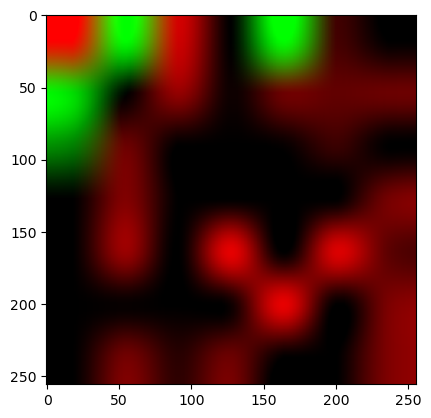

In [10]:
plt.imshow(
    to_pil_image(fmgcam_hm, mode='RGB').resize((IMG_H, IMG_H), resample=Image.BICUBIC)
)

## GCAM Prediction Type

In [11]:
localisation_service = LocalisationService()
preds, sorted_pred_index, grads, acts = prediction_service.get_model_pred(
    art_img_tensor.to(device),
    G_CAM_TYPE
)

In [12]:
len(preds), np.argmax(preds)

(30, 24)

In [13]:
len(grads), len(acts)

(1, 1)

In [14]:
grads[0][0].size(), acts[0][0].size()

(torch.Size([1, 3072, 7, 7]), torch.Size([3072, 7, 7]))

## G CAM localisation test

In [15]:
gcam_hm = localisation_service.generate_gcam(
    gradients=grads[0],
    activations=acts[0]
)
gcam_hm.size()

torch.Size([7, 7])

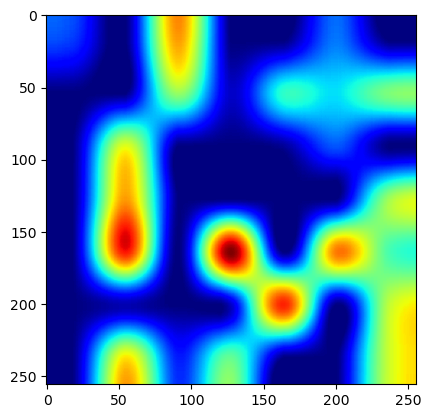

In [16]:
plt.imshow(
    to_pil_image(gcam_hm, mode='L').resize((IMG_H, IMG_H), resample=Image.BICUBIC), cmap='jet'
)